In [1]:
# basics
import os
import pandas as pd
import numpy as np
import missingno as msno

# plots
import  matplotlib.pyplot as  plt
import matplotlib.patches as mpatches
import seaborn as sns

# statistics plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot

# statistical tests and auto arima
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
from arch import arch_model


# metrics
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

ModuleNotFoundError: No module named 'arch'

In [ ]:
os.chdir('../..')

In [ ]:
df = pd.read_csv('data/data_returns_clean.csv', sep=';', index_col='date',  parse_dates=['date'], usecols=['date','Gold'])
df.dropna(inplace=True) 
dfp = pd.read_csv('data/data_nominal_clean.csv', sep=';', index_col='date',  parse_dates=['date'], usecols=['date','Gold'])


# 1. Brief EDA

Text(0.5, 1.0, 'Gold returns per troy oz 1986-01-02 to 2023-01-06')

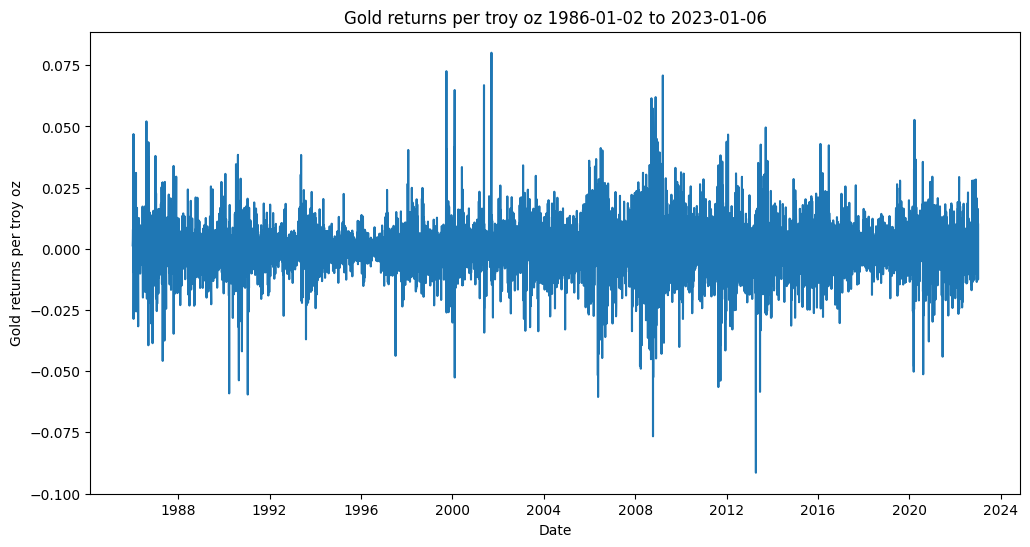

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(x=df.index, y='Gold', data=df, ax=ax)
ax.set_ylabel('Gold returns per troy oz')
ax.set_xlabel('Date')
ax.set_title('Gold returns per troy oz 1986-01-02 to 2023-01-06')

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


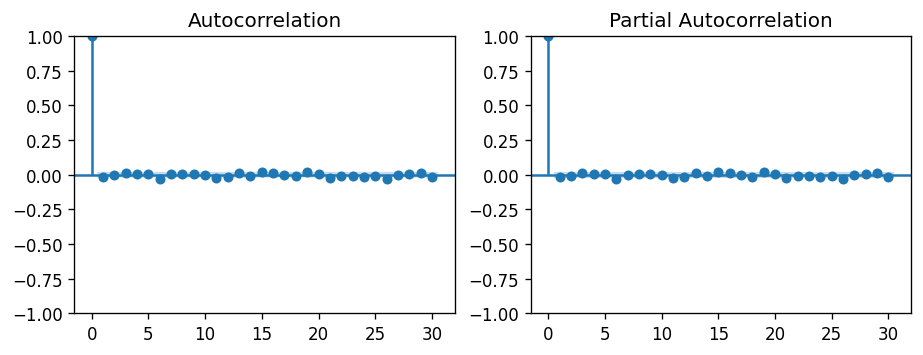

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
plot_acf(df['Gold'], ax=axes[0], lags=30)
plot_pacf(df['Gold'], ax=axes[1], lags=30)

plt.show()

In [ ]:
def ts_plot(residuals, stan_residuals, lags=20):
    residuals.plot(title='GARCH Residuals', figsize=(10, 5))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].set_title('GARCH Standardized Residuals KDE')
    ax[1].set_title('GARCH Standardized Resduals Probability Plot')    
    residuals.plot(kind='kde', ax=ax[0])
    probplot(stan_residuals, dist='norm', plot=ax[1])
    plt.show()
    acf = plot_acf(stan_residuals, lags=lags)
    pacf = plot_pacf(stan_residuals, lags=lags)
    acf.suptitle('GARCH Model Standardized Residual Autocorrelation', fontsize=14)
    acf.set_figheight(5)
    acf.set_figwidth(10)
    pacf.set_figheight(5)
    pacf.set_figwidth(10)
    plt.show()

Rescaling df

In [ ]:
df = df*100
df.head()

,Gold
date,
1986-01-03,0.137910
1986-01-06,0.382555
1986-01-07,0.609756
1986-01-08,0.787879
1986-01-09,0.270595


Calculating historical volatility

In [ ]:
dfv = pd.DataFrame(df.Gold.rolling(20).std()).dropna()
dfv

,Gold
date,
1986-01-30,1.544595
1986-01-31,1.647574
1986-02-03,1.672101
1986-02-04,1.783055
1986-02-05,1.780024
...,...
2022-12-30,1.013520
2023-01-03,0.873343
2023-01-04,0.841911


In [ ]:
# dft = pd.DataFrame()
# dft['log_ret'] = np.log(dfp['Gold']/dfp['Gold'].shift())
# dft.index = dfp.index
# dft.dropna(inplace=True)
# volatility = pd.DataFrame(dft['log_ret'].rolling(20).std()**.5)
# volatility.rename(columns={'log_ret':'hv'}, inplace=True)
# volatility

# 2. Full period estimation - looking for optimal *p* and *q*

In [ ]:
bic_garch = []

for p in range(1, 5):
    for q in range(1, 5):
        garch = arch_model(df, mean='zero',vol='GARCH', p=p, o=0, q=q)\
                .fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q

print(f'Best params are:\np - {best_param[0]}\nq - {best_param[1]}')

Best params are:
p - 1
q - 3


In [ ]:
model = arch_model(df, vol = 'GARCH', mean='zero', p=best_param[0], o=0, q=best_param[1])
#Fit the model
model_fit_full = model.fit(disp='off')

In [ ]:
model_fit_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11966.2
Distribution:                  Normal   AIC:                           23942.4
Method:            Maximum Likelihood   BIC:                           23978.0
                                        No. Observations:                 9148
Date:                Mon, May 08 2023   Df Residuals:                     9148
Time:                        13:52:21   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.4532e-03  3.242e-03      1.990  4.657e-02 [9.810e-05,1.281e-02]
alpha[1]       0.0870  2.112e-02      4.119  3.806e-05   [4.559e-02,  0.128]
beta[1]        0.2137      0.175      1.222      0.222     [ -0.129,  0.556]
beta[2]        0.3697      0.151      2.446  1.444e-02   [7.348e-02,  0.666]
beta[3]        0.3274      0.182      1.796  7.247e-02  [-2.986e-02,  0.685]
============================================================================

Covariance estimator: robust
"""

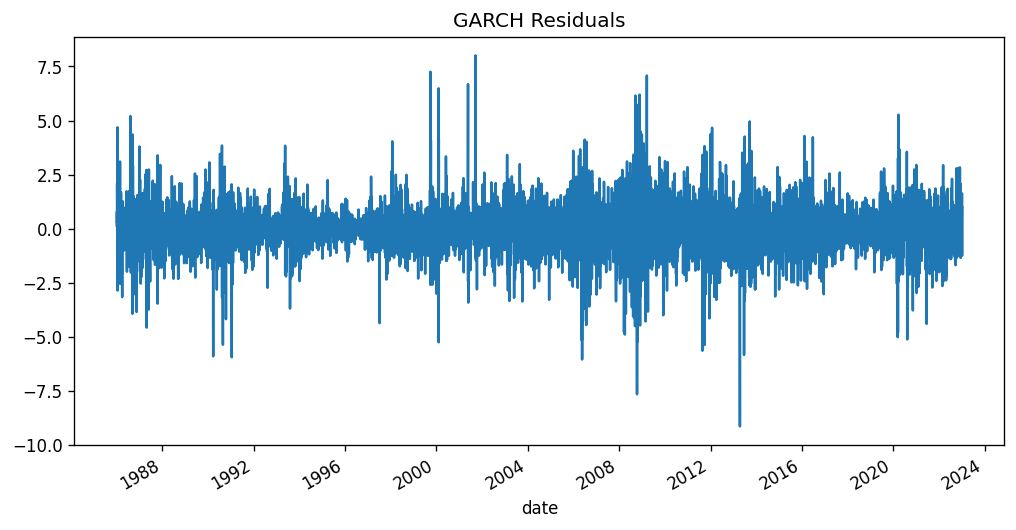

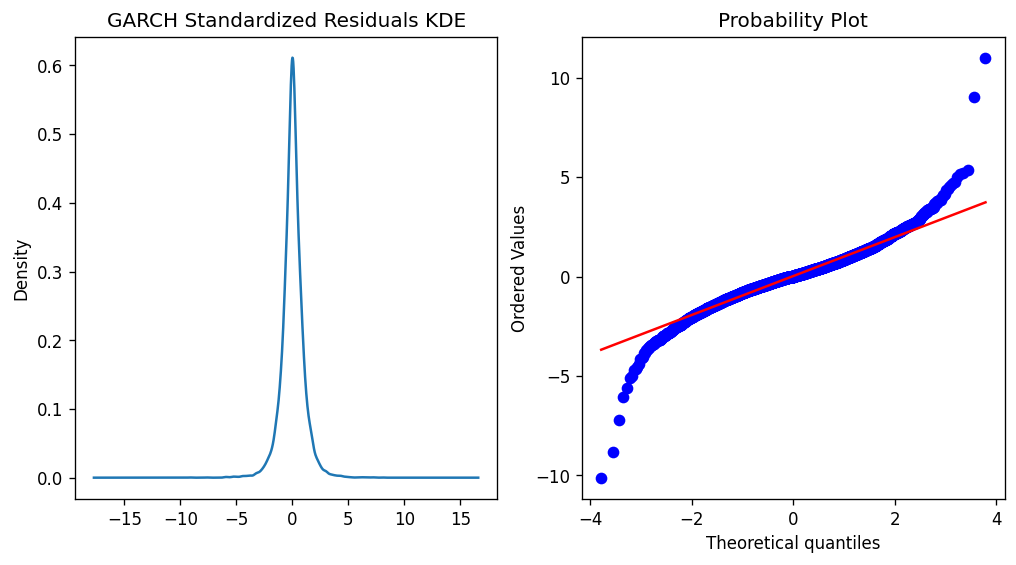

c:\Users\maxim\Documents\GitHub\gold-forecast\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


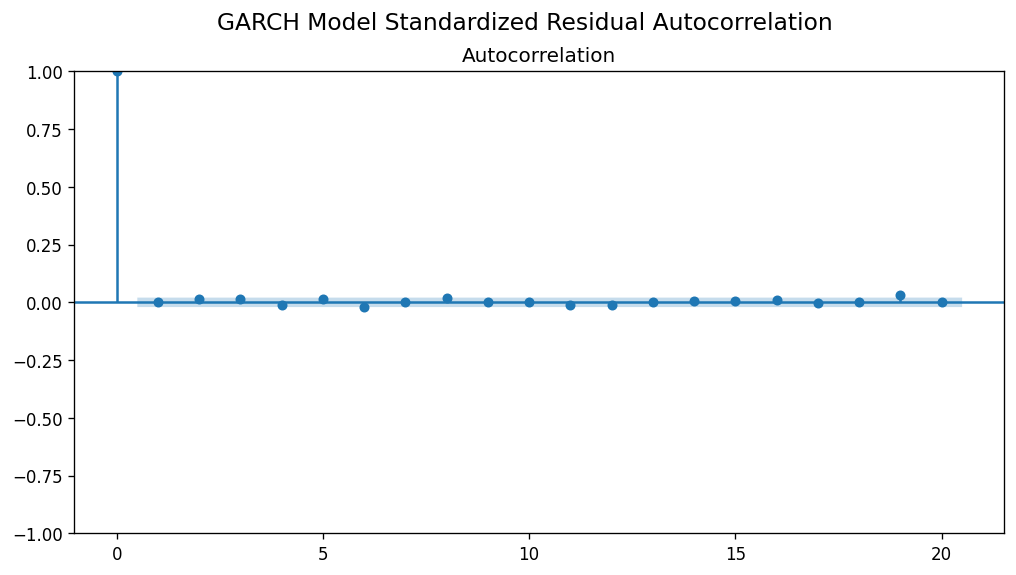

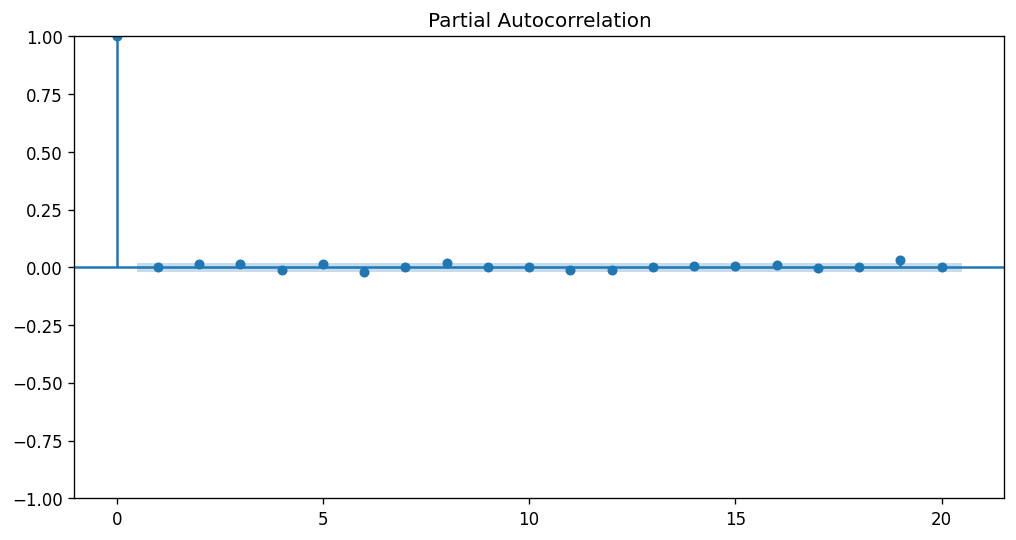

In [ ]:
resid_full = model_fit_full.resid
st_resid_full = np.divide(resid_full, model_fit_full.conditional_volatility)
ts_plot(resid_full, st_resid_full)

In [ ]:
garch_full = pd.DataFrame(model_fit_full._volatility)
garch_full.index = df.index

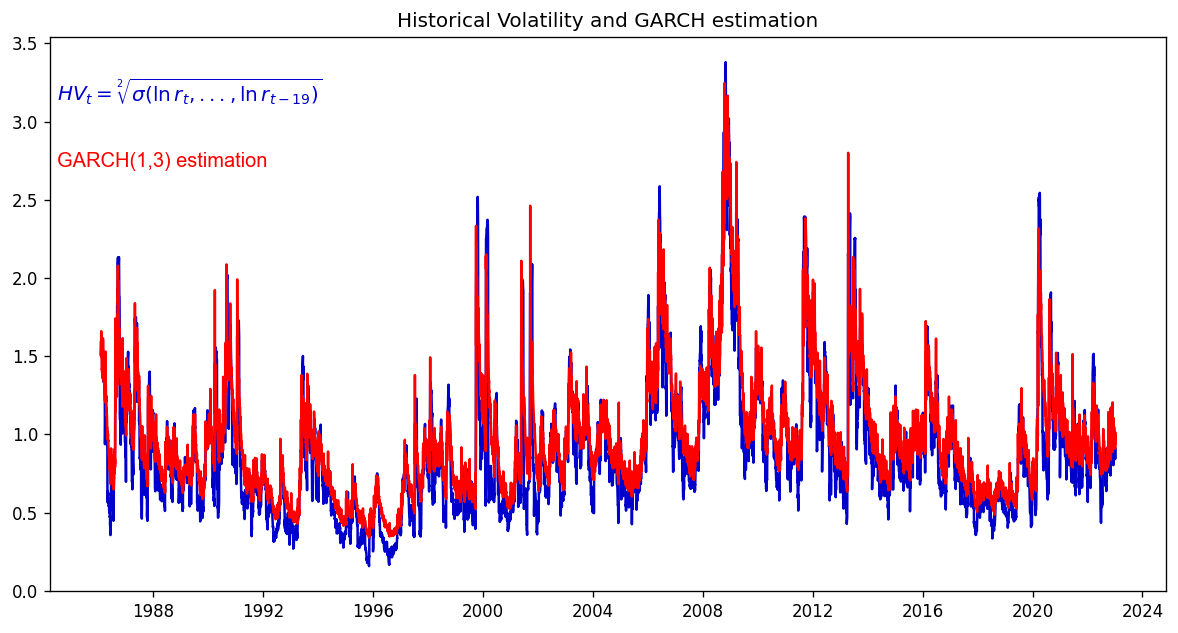

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

font1 = {'family': 'arial',
        'color':  'mediumblue',
        'weight': 'normal',
        'size': 12,
        }
font2 = {'family': 'arial',
        'color':  'red',
        'weight': 'normal',
        'size': 12,
        }

ax.plot(dfv.iloc[19:], color='mediumblue')
ax.plot(garch_full.iloc[19:], color='red')
fig.text(x=0.13, y=0.79, s=r'$HV_t = \sqrt[2]{\sum (r_t, ... , r_{t-19}}$', fontdict=font1)
fig.text(x=0.13, y=0.7, s=r'GARCH(1,3) estimation', fontdict=font2)
ax.set_title('Historical Volatility and GARCH estimation')
plt.show()

Twenty day rolling std is very close to volatility estimated by GARCH(1,1), the rolling std will be used when training neural network based models in other notebooks.

# 3. GARCH forecasts - Walk Forward validation
## A) Period 1

In [16]:
# data split
y_train_v_p1, y_test_v_p1 = df.iloc[:-60], df.iloc[-60:-40]

# historical vol split
hv_train_p1, hv_test_p1 = dfv.iloc[:-60], dfv.iloc[-60:-40]

In [17]:
#Define a GARCH model
model_garchp1 = arch_model(y_train_v_p1,dist="Normal", vol = 'GARCH', p=best_param[0], q=best_param[1])
#Fit the model
model_fit_garchp1 = model_garchp1.fit(disp='off')
#Summary of the model
model_fit_garchp1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11882.3
Distribution:                  Normal   AIC:                           23776.5
Method:            Maximum Likelihood   BIC:                           23819.2
                                        No. Observations:                 9088
Date:                Mon, May 08 2023   Df Residuals:                     9087
Time:                        13:52:26   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.8817e-03  8.454e-03      0.814      0.416 [-9.688e-03,2.345e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.5355e-03  3.313e-03      1.973  4.851e-02 [4.277e-05,1.303e-02]
alpha[1]       0.0877  2.160e-02      4.058  4.952e-05   [4.532e-02,  0.130]
beta[1]        0.2191      0.179      1.226      0.220     [ -0.131,  0.569]
beta[2]        0.3646      0.152      2.405  1.619e-02   [6.742e-02,  0.662]
beta[3]        0.3264      0.186      1.756  7.903e-02  [-3.784e-02,  0.691]
============================================================================

Covariance estimator: robust
"""

In [18]:
garch_hat_p1 = model_fit_garchp1.forecast(start = hv_train_p1.index.max(), horizon=y_test_v_p1.shape[0], reindex=False)

In [19]:
garch_hat_p1 = garch_hat_p1.variance.values
garch_hat_p1 = pd.DataFrame(garch_hat_p1.reshape(20))
garch_hat_p1.index = y_test_v_p1.index
garch_hat_p1.head()

,0
date,
2022-10-11,0.969327
2022-10-12,0.990391
2022-10-13,1.004244
2022-10-14,0.992091
2022-10-17,1.000289


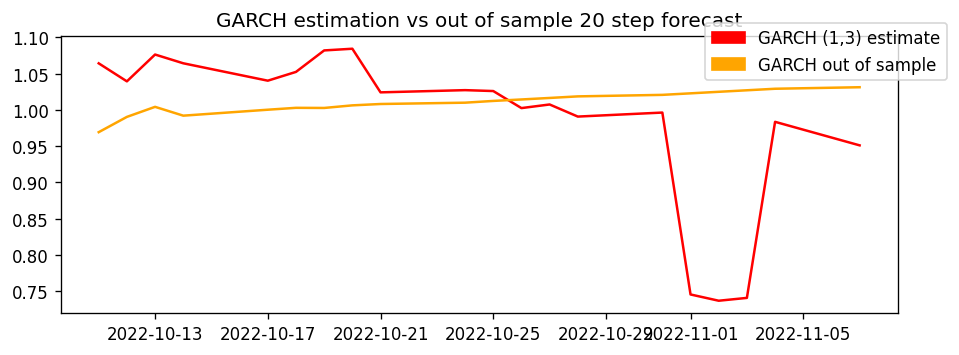

In [20]:
plt.plot(hv_test_p1, color='red', label='Actual volatility')
plt.plot(garch_hat_p1, color='orange', label='Predicted volatility')
plt.title('GARCH estimation vs out of sample 20 step forecast')
red_patch = mpatches.Patch(color='red', label='GARCH (1,3) estimate')
orange_patch = mpatches.Patch(color='orange', label='GARCH out of sample')
plt.legend(handles=[red_patch, orange_patch], bbox_to_anchor=(0.76,0.81))
plt.show()

In [21]:
g_mae = mean_absolute_error(hv_test_p1, garch_hat_p1)
g_mape = mean_absolute_percentage_error(hv_test_p1, garch_hat_p1)
g_mse = mean_squared_error(hv_test_p1, garch_hat_p1)
g_rmse = np.sqrt(g_mse)

In [22]:
res_dict = {'period':[], 'MAE':[], 'MAPE':[], 'MSE':[], 'RMSE':[]}

res_dict['period'].append(1)
res_dict['MAE'].append(g_mae)
res_dict['MAPE'].append(g_mape)
res_dict['MSE'].append(g_mse)
res_dict['RMSE'].append(g_rmse)

In [23]:
print(f"MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}")

MAE: 0.0816192522216714
MAPE: 0.09503269841837818
MSE: 0.01454112417611366
RMSE: 0.12058658373183005


## B) Period 2

In [24]:
# data split
y_train_v_p2, y_test_v_p2 = df.iloc[:-40], df.iloc[-40:-20]

# historical vol split
hv_train_p2, hv_test_p2 = dfv.iloc[:-40], dfv.iloc[-40:-20]

In [25]:
#Define a GARCH model
model_garchp2 = arch_model(y_train_v_p2,dist="Normal", vol = 'GARCH', p=best_param[0], q=best_param[1])
#Fit the model
model_fit_garchp2 = model_garchp2.fit(disp='off')

In [26]:
garch_hat_p2 = model_fit_garchp2.forecast(start = hv_train_p2.index.max(), horizon=y_test_v_p2.shape[0], reindex=False)

In [27]:
garch_hat_p2 = garch_hat_p2.variance.values
garch_hat_p2 = pd.DataFrame(garch_hat_p2.reshape(20))
garch_hat_p2.index = y_test_v_p2.index
garch_hat_p2.head()

,0
date,
2022-11-08,0.832662
2022-11-09,1.021463
2022-11-10,1.069604
2022-11-11,0.977808
2022-11-14,1.029922


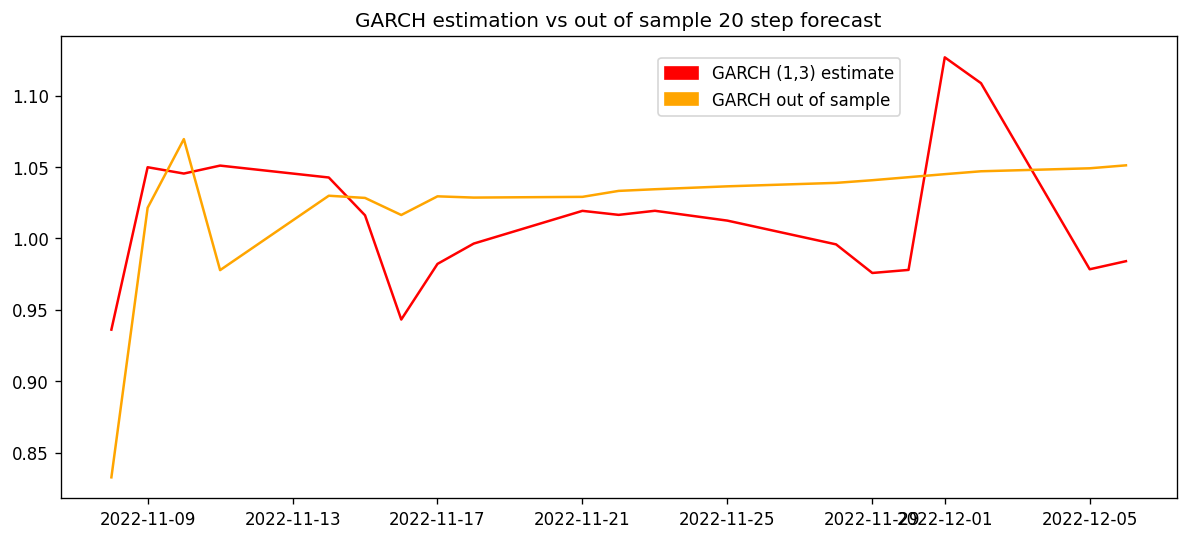

In [28]:
plt.figure(figsize=(12,5))
plt.plot(hv_test_p2, color='red', label='Actual volatility')
plt.plot(garch_hat_p2, color='orange', label='Predicted volatility')
plt.title('GARCH estimation vs out of sample 20 step forecast')
red_patch = mpatches.Patch(color='red', label='GARCH (1,3) estimate')
orange_patch = mpatches.Patch(color='orange', label='GARCH out of sample')
plt.legend(handles=[red_patch, orange_patch], bbox_to_anchor=(0.76,0.81))

In [29]:
g_mae = mean_absolute_error(hv_test_p2, garch_hat_p2)
g_mape = mean_absolute_percentage_error(hv_test_p2, garch_hat_p2)
g_mse = mean_squared_error(hv_test_p2, garch_hat_p2)
g_rmse = np.sqrt(g_mse)

In [30]:
res_dict['period'].append(2)
res_dict['MAE'].append(g_mae)
res_dict['MAPE'].append(g_mape)
res_dict['MSE'].append(g_mse)
res_dict['RMSE'].append(g_rmse)

In [31]:
print(f"MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}")

MAE: 0.04635758627268636
MAPE: 0.046125647600698295
MSE: 0.0028953887933489885
RMSE: 0.053808817059558076


## C) Period 3

In [32]:
# data split
y_train_v_p3, y_test_v_p3 = df.iloc[:-20], df.iloc[-20:]

# historical vol split
hv_train_p3, hv_test_p3 = dfv.iloc[:-20], dfv.iloc[-20:]

In [33]:
#Define a GARCH model
model_garchp3 = arch_model(y_train_v_p3,dist="Normal", vol = 'GARCH', p=best_param[0], q=best_param[1])
#Fit the model
model_fit_garchp3 = model_garchp3.fit(disp='off')
#Summary of the model
model_fit_garchp3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   Gold   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11938.7
Distribution:                  Normal   AIC:                           23889.3
Method:            Maximum Likelihood   BIC:                           23932.0
                                        No. Observations:                 9128
Date:                Mon, May 08 2023   Df Residuals:                     9127
Time:                        13:52:29   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.4246e-03  8.441e-03      0.880      0.379 [-9.120e-03,2.397e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.5176e-03  3.275e-03      1.990  4.658e-02 [9.857e-05,1.294e-02]
alpha[1]       0.0878  2.122e-02      4.141  3.464e-05   [4.626e-02,  0.129]
beta[1]        0.2067      0.171      1.209      0.227     [ -0.128,  0.542]
beta[2]        0.3677      0.149      2.474  1.337e-02   [7.639e-02,  0.659]
beta[3]        0.3356      0.181      1.850  6.424e-02  [-1.985e-02,  0.691]
============================================================================

Covariance estimator: robust
"""

In [34]:
garch_hat_p3 = model_fit_garchp3.forecast(start = hv_train_p3.index.max(), horizon=y_test_v_p3.shape[0], reindex=False)

In [35]:
garch_hat_p3 = garch_hat_p3.variance.values
garch_hat_p3 = pd.DataFrame(garch_hat_p3.reshape(20))
garch_hat_p3.index = y_test_v_p3.index
garch_hat_p3.head()

,0
date,
2022-12-07,1.061510
2022-12-08,1.017712
2022-12-09,1.039182
2022-12-12,1.042999
2022-12-13,1.037321


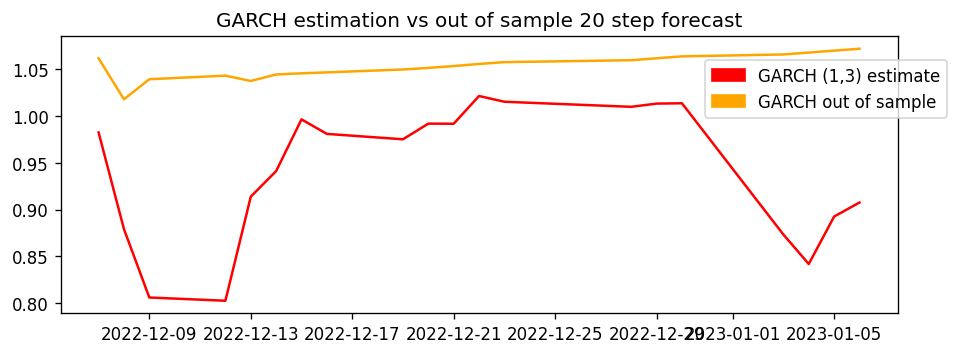

In [36]:
plt.plot(hv_test_p3, color='red', label='Actual volatility')
plt.plot(garch_hat_p3, color='orange', label='Predicted volatility')
plt.title('GARCH estimation vs out of sample 20 step forecast')
red_patch = mpatches.Patch(color='red', label='GARCH (1,3) estimate')
orange_patch = mpatches.Patch(color='orange', label='GARCH out of sample')
plt.legend(handles=[red_patch, orange_patch], bbox_to_anchor=(0.76,0.81))

In [37]:
g_mae = mean_absolute_error(hv_test_p3, garch_hat_p3)
g_mape = mean_absolute_percentage_error(hv_test_p3, garch_hat_p3)
g_mse = mean_squared_error(hv_test_p3, garch_hat_p3)
g_rmse = np.sqrt(g_mse)

In [38]:
res_dict['period'].append(3)
res_dict['MAE'].append(g_mae)
res_dict['MAPE'].append(g_mape)
res_dict['MSE'].append(g_mse)
res_dict['RMSE'].append(g_rmse)

In [39]:
print(f"MAE: {g_mae}\nMAPE: {g_mape}\nMSE: {g_mse}\nRMSE: {g_rmse}")

MAE: 0.11060660551549435
MAPE: 0.1237679557502472
MSE: 0.01697743811103821
RMSE: 0.13029749848342528


# All Results

In [40]:
pd.DataFrame(res_dict)

,period,MAE,MAPE,MSE,RMSE
0,1,0.081619,0.095033,0.014541,0.120587
1,2,0.046358,0.046126,0.002895,0.053809
2,3,0.110607,0.123768,0.016977,0.130297


Text(0.5, 0, 'Date')

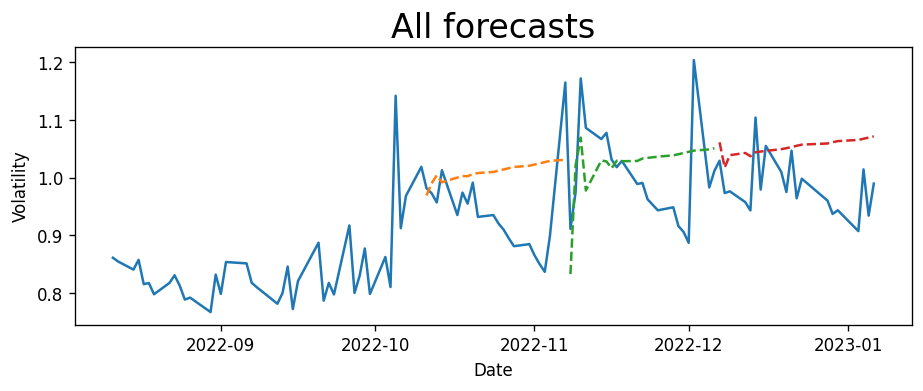

In [41]:
plt.plot(garch_full.iloc[-100:].index, garch_full.iloc[-100:][0])
#plt.plot(dfv.iloc[-150:].index, dfv.iloc[-150:].Gold)
plt.plot(garch_hat_p1.index, garch_hat_p1[0], linestyle='--')
plt.plot(garch_hat_p2.index, garch_hat_p2[0], linestyle='--')
plt.plot(garch_hat_p3.index, garch_hat_p3[0], linestyle='--')
plt.title('All forecasts', fontsize=20)
plt.ylabel('Volatility')
plt.xlabel('Date')